In this second practical session, we explore surface deformation algorithms with two applications : surface parametrization for texture mapping and as-rigid-as possible deformation for non-rigid alignment.

Program for today:
1. Surface Parameterisation

    a. Tutte embedding,

    b. Angle-preserving map with free boundary.
    
2. Surface alignment

    a. Rigid alignment with Iterative Closest Point,

    b. ARAP for non-rigid alignment.


# Environment Setup

You'll need to install meshplot, using either:
- Conda:
   - ```conda install -c conda-forge meshplot```
- Pip:
   - ```pip install pythreejs```
   - ```pip install git+https://github.com/skoch9/meshplot.git```

Works best with jupyter notebook.

In [1]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import scipy.sparse
from scipy.sparse import csc_matrix

# THE FOLLOWING COME FROM THE PROVIDED DATA, DO NOT TRY TO PIP INSTALL THEM
import plot_utils as plu
import mesh_utils
from mesh_utils.mesh import TriMesh

# Surface Parameterisation

Given a triangle mesh with triangle list $T$ ($n_f \times 3$ array of integers) and vertex coordinates $X$ ($n_v \times 3$ array of floats), a parametrization is simply an assignment of planar coordinates $U$ ($n_v \times 2$ array of floats) for each vertex of the mesh. This parametrization will be vizualized by mapping a texture in planar coordinates to 3D coordinates.

## Tutte embedding

The most simple way of computing planar coordinates is to fix the boundary of the mesh to predefined positions (in this example a unit circle) and place the inner vertices at the barycenter of their neighbours. For a boundary vertex $j$, the coordinates $(u_j,v_j)$ are constrained to the position $(\bar{u}_j,\bar{v}_j)$. More precisely, the planar coordinates $(u_i,v_i)$ of vertex $i$ satisfies the system of equations:
\begin{array}{lll}
    \sum_{j \in N_i} w_{ij} (u_j - u_i) = 0, & \sum_{j \in N_i} w_{ij} (v_j - v_i) = 0, & \text{ for all boundary vertices } i, \\
    u_j = \bar{u}_j, & u_j = \bar{v}_j, & \text{ for all interior vertices } j,
\end{array}
where $w_{ij}$ are the cotan-weights computed in the previous practical session and $N_i$ is the set of vertices linked to $i$ by an edge.

This system of linear equations can be easily rewritten in term of Laplacian matrix $W$ computed in the previous session:
$$
\begin{array}{l}
(W u)_i = 0, \text{ and } (W v)_i = 0  \text{ for all interior vertices $i$,} \\
u_j = \bar{u}_j, \text{ and } v_j = \bar{v}_j \text{ for all boundary vertices $j$.}
\end{array}
$$

Let `id_int` and `id_bnd` be the lists of interior and boundary indices. The boundary coordinates `u[id_bnd]` and `v[id_bnd]` are coordinates evenly distributed on a circle.  With the boundary coordinates `u[id_bnd]` given, we want to solve the system of linear equations `W[id_int,:][:,id_int]*u[id_int] =-W[id_int,:][:,id_bnd]*u[id_bnd]` for the variables `u[id_int]`.

This is done in three steps:
1. Build the lists `id_int` and `id_bnd`
2. Solve the constrained system of linear equations
3. Vizualize the texture

###  QUESTION 1 - Border Edges

**Given a set of triangles, compute the list of (unordered) edges which lie at the border**

In [2]:
def get_border_edges(triangles:np.array)->list[list]:
    """
    Get the border edges of a mesh. In no particular order

    Parameters
    ----------
    triangles : ndarray of shape (n_triangles, 3)

    Returns
    -------
    border_edges : list of list of length n_border_edges.
                   The border edges of the mesh. Element i contains the two
                     vertices of the i-th border edge. 
    """
    # YOUR CODE HERE
    not_border=[]
    border_edges=[]
    triangles=np.sort(triangles) #get a sorted version of it , imporatant if edges are not sorted
    for triangle in triangles:
        first_edge=triangle[1],triangle[0]
        second_edge=triangle[2],triangle[1]
        third_edge=triangle[2],triangle[0]
        assert first_edge!=second_edge
        for edge in [first_edge,second_edge,third_edge]:
            if edge in not_border:
                continue 
            elif edge in border_edges:
                not_border.append(edge)
                border_edges.remove(edge)
            else: 
                border_edges.append(edge)
    #TODO: optimized version of it 
    return border_edges#,not_border

In [3]:
mesh1 = TriMesh('./data/sphere_cut_uv.obj').process(k=0)
print(type(mesh1.faces))
border_edges = get_border_edges(mesh1.faces)
# Visualize the border. It is here just a cut of the sphere

plu.plot(mesh1, points=np.unique(border_edges))
# seems correct 

<class 'numpy.ndarray'>


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [ ]:
plu.plot(mesh1)


### Question 2 - Orderd points on a circle

**Write a function to generate evenly spaced points on the circle in a counterclockwise order.**
These are going to be the fixed positions of our border vertices

In [4]:
def get_n_points_on_circle(n_points):
    """
    Builds n_points evenly spaced points on the unit circle.

    Parameters
    ----------
    n_points : int
        Number of points to generate

    Returns
    -------
    points : ndarray of shape (n_points, 2)
        The points on the unit circle
    """
    # YOUR CODE HERE
    list_args=[2*np.pi*k/n_points for k in range(n_points)]
    points=np.array(
        [
            (np.cos(args),np.sin(args)) for args in list_args
        ]
    )
    return points

(-1.1, 1.1, -1.046162167924669, 1.046162167924669)

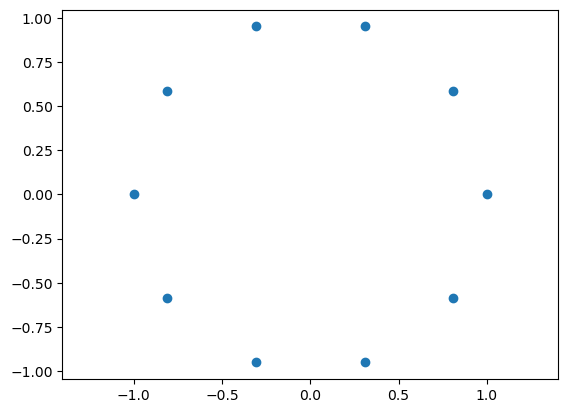

In [5]:
circle_points = get_n_points_on_circle(10)
plt.figure(dpi=100)
plt.scatter(circle_points[:,0], circle_points[:,1])
plt.axis('equal')

### Question 3 - Solving the Embedding

**Solve for the uv coordinate using ```scipy.sparse.linalg.spsolve```**

Tip: The slicing ```W[id_int,id_int]``` does not work on a scipy sparse matrix, instead use ```W[id_int,:][:,id_int]```.

Because the function `get_n_points_on_circle` gives an *ordered* set of points on the circle but the function `get_border_edges` outputs vertices which are *unordered*, we will need to *sort* the list of border edges. We provide the function ```build_ordered_edges``` below which generates an *ordered* list of border edges using the output of ```get_border_edges``` defined in Question 1.

In [6]:
def find_next_edge(current_edge, remaining_edges):
        for i, edge in enumerate(remaining_edges):
            if current_edge[1] in edge:
                return i, edge #if edge[0]==current_edge[1] else edge[::-1]
        return None, None

def build_ordered_edges(triangles):
    """
    Compute an ordered list of edges that form a path around the border of the mesh.
    in lexicographical order ! 
    Parameters
    ----------
    triangles : ndarray of shape (n_triangles, 3)

    Returns
    -------
    ordered_edge_list : list of list of length n_border_edges.
                        The border edges of the mesh. Element i contains the two
                        vertices of the i-th border edge.
    """
    
    border_edges = get_border_edges(triangles)  # (p,2)
    remaining_edges = border_edges.copy()#.tolist()
    
    ordered_edge_list = []
    
    current_edge = remaining_edges[0]
    ordered_edge_list.append(current_edge)
    
    remaining_edges.pop(0)
        
    while remaining_edges:
        
        i_edge, next_edge = find_next_edge(current_edge, remaining_edges)
        #print(len(remaining_edges), i_edge, next_edge, current_edge)
        if next_edge:
            # Add the next edge to the ordered list
            #print("toadd:",  next_edge if next_edge[0]==current_edge[1] else [next_edge[1], next_edge[0]])
            ordered_edge_list.append(next_edge if next_edge[0]==current_edge[1] else [next_edge[1], next_edge[0]])

            # Remove the next edge from the list of border edges
            remaining_edges.pop(i_edge)

            # Update the current edge for the next iteration
            current_edge = ordered_edge_list[-1]
        else:
            # If no next edge is found, break the loop
            break
    return ordered_edge_list     

In [7]:
# Load the mesh and compute the Laplacian
mesh1 = TriMesh('./data/sphere_cut_uv.obj').process(k=0)
ordered_edges = build_ordered_edges(mesh1.faces)


In [9]:
#Defined used function


import scipy.sparse as sparse

def getuv(dim_solve:int,mesh1,id_boundary:np.array,boundary_points_2d:np.array):
    """ Get the tutte embedding of a mesh with boundary conditions.

    Parameters
    ----------
    dim_solve : int
        the dimension of the mesh
    mesh1 : mesh
        incoming mesh
    boundary_points : np.array (k, 2)
        boundary points 
    id_boundary: np.array (k,) int
        the indices of the boundary points in the mesh that will be mapped into boundary points

    Returns
    -------
    _type_
        _description_
    """    
    n=mesh1.n_vertices
    #Will be LU=Ubarre
    # Computationnaly speaking Ubarre[0] will be the result of x axis and Ubarre[1] for y axis
    Ubarre=[np.zeros(shape=(mesh1.n_vertices)) for _ in range(dim_solve)] 
    L=[np.zeros(shape=(mesh1.n_vertices,mesh1.n_vertices))  for _ in range(dim_solve)]

    #Update the equation for boundary vertices
    #update  Ubarre
    for dim in range(dim_solve):
        Ubarredim=Ubarre[dim]
        Ubarredim[id_boundary]=boundary_points_2d[:,dim]
    # Update L  to be diagonal on constraint value
    for dim in range(dim_solve):
        Ldim=L[dim]
        """         diag=Ldim[np.ix_(id_boundary,id_boundary)]
        to_fill=np.ones(len(id_boundary)) """
        #np.fill_diagonal(a=diag,val=to_fill)
        #np.fill_diagonal(Ldim[np.ix_(id_boundary, id_boundary)], to_fill)
        Ldim[np.ix_(id_boundary, id_boundary)]=np.eye(len(id_boundary))
               #print("non zero diag",np.nonzero(diag))

    #compute id_int , we take care of interior point
    id_int=[k for k in range(n) if k not in id_boundary]
    
    # get the cotangent weight
    # In the slide we hsould compute Lu=U avec u unknown and U = 0 if interior and equal circle points otherwise, However according to the tutorial, 
    #if you should Lij appropriately, it is in fact the contangent weight 
    from mesh_utils.laplacian import cotangent_weights
    W=cotangent_weights(vertices=mesh1.vertices,faces=mesh1.faces)
    for dim in range(dim_solve):
        Ldim=L[dim]
        # We have Wu(i)=0 
        Ldim[id_int,:]=W.todense()[id_int,:]
    # Update Ubarre for interior points
    #As ubarre is defined as np.zeros, we don't need to take care of it 


    # solve it 
    resultat=[]
    L_solve=[]
    Ubarre_solve=[]
    for dim in range(dim_solve):
        L_solve.append(sparse.csc_matrix(L[dim]))
        Ubarre_solve.append(Ubarre[dim])
    
    for dim in range(dim_solve):
        print("solving for dim",dim)

        Ldim=L_solve[dim]
        Ubarredim=Ubarre[dim]#sparse.csc_matrix(Ubarre[dim],shape=Ubarre[dim].shape)

        result=scipy.sparse.linalg.spsolve(A=Ldim,b=Ubarredim)
        resultat.append(result)
    uv_total =   np.stack(resultat,axis=1)
    return uv_total






In [10]:
#TODO Compute the embedding u,v using the text above.
# Get the list of ordered edges and the Laplacian
import copy 
ordered_edges = build_ordered_edges(mesh1.faces) #at the bondary
dim_solve=2
# first get the boundary condition 
# ordered_edges[i] will be sent to circle_points[i]
# get the list of indices of boundary indices, as ordered edges is a path it is ordered_edges[:,1] with the first elemnt in addition

id_boundary=[ordered_edges[0][0]]
id_boundary=id_boundary+np.array(ordered_edges)[:,1].tolist()
circle_points=get_n_points_on_circle(len(id_boundary))
boundary_points_2d=circle_points # boundary points 2d

uv_total=getuv(dim_solve=dim_solve,mesh1=mesh1,id_boundary=id_boundary,boundary_points_2d=boundary_points_2d)
### (n,2) computed UV coordinates (takes more than 1 line)

flat_coords =  np.zeros((mesh1.n_vertices,3))
flat_coords[:,:2] = uv_total

solving for dim 0
solving for dim 1


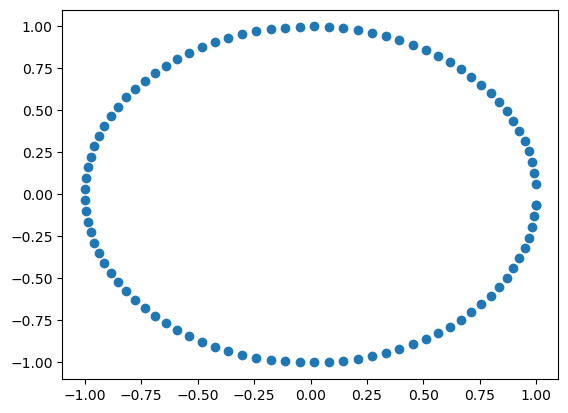

In [12]:
# Check that the constraints are good (normally naturally, since you built the system accordingly
plt.scatter(flat_coords[id_boundary, 0], flat_coords[id_boundary, 1])

In [13]:
# Visualize the texture on the mesh
uv_map = mesh_utils.read_obj_texture('./data/sphere_cut_uv.obj')[-1]


plu.plot_textured_mesh(mesh1, uv_map, points=np.unique(np.array(border_edges).flatten()), wireframe=True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [14]:
# Visualize the results

# Flattened coordinates with reegular grid
plu.plot_texture(flat_coords, mesh1.faces, uv_total, wireframe=True) 

# We can take the regular grid back to the sphere
#plu.plot_texture(mesh1.vertices, mesh1.faces, uv_map, wireframe=True)

# Or take the Texture of the sphere to the flat world
#plu.plot_texture(flat_coords, mesh1.faces, uv_total, wireframe=True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000786…

Let's now visualize how it would render on the Earth

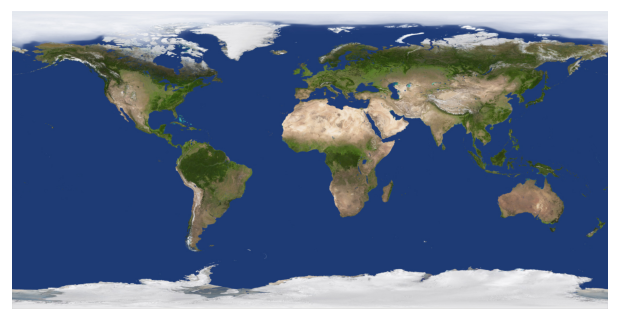

In [15]:
image = plt.imread('data/earth_daymap.jpg')
plt.figure(dpi=120)
plt.imshow(image)
plt.axis('off');

In [16]:
os.makedirs('results', exist_ok=True)
shutil.copyfile('data/earth_daymap.jpg', 'results/earth_daymap.jpg')


# THIS EXPORTS A .OBJ FILE WITH TEXTURE AND MATERIAL INFORMATION. DOWNLOAD AND OPEN WITH MESHLAB
TriMesh(mesh1.vertices, mesh1.faces).export_texture('results/tutte_earth.obj', uv_map, texture_im='earth_daymap.jpg')
TriMesh(flat_coords, mesh1.faces).export_texture('results/tutte_earth_flat.obj', uv_map, texture_im='earth_daymap.jpg')

## Least Square Conformal Map

Conformal maps are special type of parametrizations which preserve angles. On a smooth surface, they are characterized by the relationship between the gradient of the coordinate $u$ and the coordinate $v$
$$ \nabla u = n \times \nabla v $$
where $n$ is the surface normal. On a triangle mesh, the coordinates $(u,v)$ are computed using a linear least-squares problem
$$ \min_{u,v} \sum_{t \in T} A_t |\nabla u - n \times \nabla v|^2 \text{ subject to the constraint: } \sum_i u_i^2 + v_i^2 = 1 $$
where $A_t$ is the area of triangle $t$. As explained in the course, the objective function can be written in term of the Laplacian matrix $W$. This leads to the smallest eigenvalue problem
$$ \min_{u,v} \begin{pmatrix} u \\ v \end{pmatrix}^\top \begin{pmatrix} W & -M \\ -M^\top & W \end{pmatrix} \begin{pmatrix} u \\ v \end{pmatrix} \text{ subject to the constraint: } \sum_i u_i^2 + v_i^2 = 1 $$
The sparse matrix $M$ of size $n_v \times n_v$ is given by
$$ M_{ij} = \left\lbrace \begin{array}{ll} 
0 & \text{if $i$ or $j$ is an interior vertex } \\
1/2 & \text{if $i$ to $j$ is a positive edge of the boundary triangle} \\
-1/2 & \text{if $i$ to $j$ is a negative edge of the boundary triangle} 
\end{array} \right.$$

Positive edges are edges that appear when going around a face in the order provided in the file. Negative edges are when going the opposite direction.

*Tips:* To assemble this matrix simply accumulate $\pm\frac{1}{2}$ values for all triangles using the triangle list using the formula above. Since interior edges appear twice in opposite direction in the mesh, their coefficient will vanish for them, and only values for border edges will remain.


1. Build the sparse matrix `M`
2. Compute the LSCM parametrization using `scipy.sparse.linalg.eigs` 
3. Extract the boundary coordinate of the parametrization and use them to compute a Tutte embedding 

### Question 4 - Build M

In [17]:
import scipy.sparse as sparse
def build_M(faces:np.array)->scipy.sparse.csr_matrix:
    """
    Build the M matrix above with values only at border edges.
    M can be build by adding the formula for M_ij for each edge of each face on the mesh.
    Coefficients at interior edges will vanish because they appear twice with opposite signs.

    Parameters
    ----------
    faces : ndarray of shape (n_faces, 3)

    Returns
    -------
    M : scipy.sparse.csr_matrix of shape (n_vertices, n_vertices)
    """
    n_vertices = len(np.unique(faces))
    M=np.zeros(shape=(n_vertices,n_vertices))
    n_face=faces.shape[1]
    for face in faces:
        for k in range(n_face):
            i,j=face[(k+1)%n_face],face[k%n_face]
            M[i,j]+=1/2 #Positive order
            M[j,i]-=1/2 #negative order
        
    # convert to sparse
    M=sparse.csr_matrix(M)

    
    return M

In [18]:
mesh1 = TriMesh("./data/sphere_cut_uv.obj").process(k=0)
M = build_M(mesh1.faces)

### Question 5 - Solve the system

Use scipy [bmat function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.bmat.html) to build sparse matrices from blocks.

Try with the two meshes (diablo doesn't have uv map)

In [19]:
#mesh1 = TriMesh("./data/diablo_cut2.obj").process(k=0)
mesh1 = TriMesh("./data/sphere_cut_uv.obj").process(k=0)
v,f,uv_map = mesh_utils.read_obj_texture('./data/sphere_cut_uv.obj')
W = mesh1.W


In [20]:
M = build_M(mesh1.faces)
system_matrix = sparse.bmat([
    [W,-M],
    [-M.transpose(),W]
])

res_eigenvalues, res_eigenvectors = scipy.sparse.linalg.eigsh(system_matrix, k=3, which='LM', sigma=-0.001)

# Check that first 2 eigenvalues are 0
print(res_eigenvalues)
np.isclose(res_eigenvalues[:2],0).all()

[-1.15359111e-16 -1.07552856e-16  1.32033361e-05]


True

In [21]:
uv_coords = res_eigenvectors[:,2].reshape((mesh1.n_vertices,2), order='F')

#plu.plot_texture(mesh1.vertices, mesh1.faces, uv_coords)
flat_coords =  np.zeros((mesh1.n_vertices,3))
flat_coords[:,:2] = uv_coords
#plu.plot_texture(flat_coords, mesh1.faces, uv_map, wireframe=True) 


# For the Sphere
plu.plot_texture(flat_coords, mesh1.faces, uv_map, wireframe=True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-2.099201…

you can again visualize with the earth map on the sphere

In [22]:
TriMesh(mesh1.vertices, mesh1.faces).export_texture('results/lscm_earth.obj', uv_map, texture_im='earth_daymap.jpg')
TriMesh(flat_coords, mesh1.faces).export_texture('results/lscm_earth_flat.obj', uv_map, texture_im='earth_daymap.jpg')

###  Question 6 - Extract the boundary of the U,V conformal coordinates and compute the tutte embedding on the same boundary

Tips: be careful with the ordering of the boundery vertices

In [23]:
#TODO

def extract_boundary_conformal(uv_coords):
    """

    Parameters
    ----------
    uv_coords : ndarray of shape (n_vertices, 2)
        _description_
    """    
    import scipy.spatial as spatial
    hull=spatial.ConvexHull(uv_coords)
    points=uv_coords
    boundary=points[hull.vertices] # scipy in 2D returns the vertices of the convex hull in counter-clockwise order
    return boundary



<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

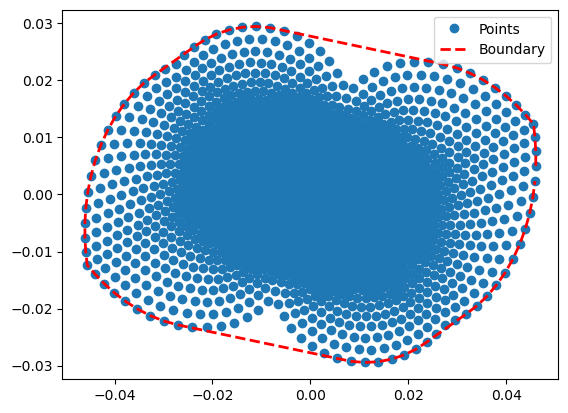

In [24]:

def plot_boundary(uv_coords):
    import matplotlib.pyplot as plt
    points=uv_coords
    boundary=extract_boundary_conformal(uv_coords)
    plt.plot(points[:,0], points[:,1], 'o',label="Points")

    plt.plot(boundary[:,0],boundary[:,1], 'r--', lw=2,label="Boundary")
    plt.legend()
    plt.show()
plot_boundary(uv_coords)

In [25]:
def apply_tutte_on_conformal(uv,mesh):
    boundary=extract_boundary_conformal(uv) #get the boundary in counterclockwise order
    ordered_edges=build_ordered_edges(mesh.faces) 
    # The issue here with boundary as convex hull is that it may have less points than the ordered edges
    #! WARNING CHANGE HERE BASED ON EXTRACT BOUNDARY
    #* heuristics for now
    n=len(boundary)
    m=len(ordered_edges)
    print(len(ordered_edges))
    id_boundary=[] 
    assert n<=m," didn't check the other case"
    for k in range(n):
        id_boundary.append(ordered_edges[int(k*m/n)][0])


    # apply tutte embedding on the boundary
    dim_solve=2
    mesh1=mesh
    id_boundary=id_boundary
    boundary_points_2d=boundary

    uv_total=getuv(dim_solve=dim_solve,mesh1=mesh1,id_boundary=id_boundary,boundary_points_2d=boundary_points_2d)

    return uv_total
uv_tutt_on_conform=apply_tutte_on_conformal(uv_coords,mesh1)

96
solving for dim 0
solving for dim 1


In [26]:
uv_map = mesh_utils.read_obj_texture('./data/sphere_cut_uv.obj')[-1]

#plu.plot_texture(mesh1.vertices, mesh1.faces, uv_coords)
flat_coords =  np.zeros((mesh1.n_vertices,3))
flat_coords[:,:2] = uv_tutt_on_conform
#plu.plot_texture(flat_coords, mesh1.faces, uv_map, wireframe=True) 


# For the Sphere
plu.plot_texture(flat_coords, mesh1.faces, uv_tutt_on_conform, wireframe=True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-2.099201…

# 2 Surface Alignment

## Iterative Closest Point

The goal of this algorithm is to align two point clouds $X = \{ x_i \}$ and $Y = \{ y_i \}$ using only rigid transformations -- translation and rotation. It is standard algorithm to align 3D scans taken from different viewpoints. The most basic implementation iterates between three steps until convergence:

1. For each point of $X$ compute the closest point in the set $Y$. This assignment is given by the table $p$
$$ p_i = \arg\min_{j} \|x_i - y_j\|^2 .$$
This can be done efficiently with a knn-search.

2. Find the translation that best align the point cloud given the assignment $p$
$$ \min_{t \in \mathbb{R}^3} \sum_i \|x_i + t - y_{p_i}\|^2 .$$
This problem can be solved exactly with the formula $t = \frac{1}{|X|}\sum_i y_i - x_i$.

3. Compute the rotation aligning the point cloud after translation:
$$ \min_{R} \sum_i \|Rx_i + t - y_{p_i}\|^2 .$$
This is an [orthogonal Procrustes problem](https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem) and can be solved efficiently using a Singular Value Decomposition ([SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition)). Let the matrix $A = \sum_i (t-y_{p_i})x_i^\top$ be decomposed as $A = U S V^\top$ where $U,V$ are unitary matrices and $S$ a diagonal matrix. The optimal rotation is given by $R = U D V^\top$ with $D$ a diagonal matrix with $+1$ on the diagonal corresponding to the two largest singular values and $\pm 1$ on the smallest singular value. The sign is chosen so that $\det R = 1$.

4. Update the position of $X$: $x_i \leftarrow Rx_i+t$


**To do:**
1. Implement the steps
2. Align the Armadilo

### Question 7 - Compute Nearest Neighbor

In [28]:
from scipy.spatial import cKDTree
def Query_CPU(xyz_query, xyz_search, K,):
    # Use scipy Kdtree to perform the query
    # XYZ MUST BE OF dimension 2 not 3
    kdtree = cKDTree(xyz_search)
    # TODO: you may need to tweak the number of num_workers, 1 is really long but -1 is can OOM
    distances, neighbors = kdtree.query(
        xyz_query, k=K, workers=-1
    )
    return distances, neighbors

def compute_nearest_neighbor(X, Y):
    """
    Compute the nearest neighbor in Y for each point in X

    Parameters:
    -----------
    X : (n, d) array of points
    Y : (m, d) array of points

    Returns:
    --------
    nearst_neighbor : (n,) array of indices of the nearest neighbor in Y for X
    """
    return Query_CPU(xyz_query=X,xyz_search=Y,K=1)[1]
    

### Question 8 - Compute optimal rotations and translation

In [29]:
import scipy  
def compute_rigid_transform(X_source, X_target):
    """
    Compute the optimal rotation matrix and translation that aligns two point clouds of the same size X_source and X_target.
    This rotation should be applied to X_source.

    Parameters:
    -----------
    X_source : (n, d) array of points
    Y_target : (n, d) array of points

    Returns:
    --------
    R : (d, d) rotation matrix
    t : (d,) translation vector
    """
    cardX=X_source.shape[0]
    print("x source",X_source.shape)
    t=1/cardX*(X_target-X_source).sum(axis=0)


    A=np.zeros((X_source.shape[1],X_source.shape[1]))
    for i in range(cardX):
        A+=np.outer(X_target[i]-t,X_source[i])
       #WHY THIS ONE ?
    U,S,Vt=np.linalg.svd(A)
    D=np.eye(X_source.shape[1])
    D[-1,-1]=np.linalg.det(np.dot(U,Vt))
    R=np.dot(np.dot(U,D),Vt)
    return R,t

### Question 9 - Apply the ICP algorithm
We provide a function to apply a rigid transformation ```R,t``` to a point cloud

In [30]:
def transform_pointcloud(X,R,t):
    """
    Transform a point cloud X by a rotation matrix R and a translation vector t.

    Parameters:
    -----------
    X : (n, d) array of points
    R : (d, d) rotation matrix
    t : (d,) translation vector

    Returns:
    --------
    X_transformed : (n, d) array of transformed points
    """

    return X @ R.T + t

In [31]:
def icp_align(X_source, Y_target, n_iter=50):
    """
    Align two point clouds X_source and Y_target using the ICP algorithm.

    Parameters:
    -----------
    X_source : (n, d) array of points
    Y_target : (m, d) array of points
    n_iter   : int - number of iterations of the ICP algorithm

    Returns:
    --------
    X_aligned : (n, d) array of aligned points
    """
    k=0
    loss=np.inf
    # TODO compute ICP alignement
    X_source=X_source.copy()
    # loss> np.linalg.norm(X_source-Y_target,ord=2) and 
    while k<n_iter:
        pi=compute_nearest_neighbor(X=X_source,Y=Y_target)
        X_target=Y_target[pi]
        R,t=compute_rigid_transform(X_source=X_source,X_target=X_target)
        X_source=transform_pointcloud(X_source,R,t)
        
        loss=np.linalg.norm(X_source-X_target,ord=2)
        print("iteration",k,"loss",loss  )
        k+=1
    return X_source

In [32]:
def plot_superimposed(mesh1, mesh2, *args, **kwargs):
    """
    Plot the superposition of the two meshes
    """
    mesh = TriMesh(np.concatenate([mesh1.vertices, mesh2.vertices], axis=0),
                   np.concatenate([mesh1.faces, mesh2.faces+mesh1.n_vertices], axis=0))
    plu.plot(mesh, *args, **kwargs)

mesh1 = TriMesh("./data/Armadillo_1.off")
mesh2 = TriMesh("./data/Armadillo_2.off")

plot_superimposed(mesh1, mesh2)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5006730…

In [33]:
# VISUALIZE ICP Result, you can change the n_iter to improve results
vert1_aligned = icp_align(mesh1.vertices, mesh2.vertices, n_iter=100)

plot_superimposed(TriMesh(vert1_aligned, mesh1.faces), mesh2)

x source (5002, 3)
iteration 0 loss 3.6396363983770734
x source (5002, 3)
iteration 1 loss 3.4912982295995043
x source (5002, 3)
iteration 2 loss 3.4020309569370015
x source (5002, 3)
iteration 3 loss 3.32685729464739
x source (5002, 3)
iteration 4 loss 3.2402665986636903
x source (5002, 3)
iteration 5 loss 3.1659697410631065
x source (5002, 3)
iteration 6 loss 3.0746347709970525
x source (5002, 3)
iteration 7 loss 2.9714334085946605
x source (5002, 3)
iteration 8 loss 2.8688418612843263
x source (5002, 3)
iteration 9 loss 2.791153369128231
x source (5002, 3)
iteration 10 loss 2.7054979942257074
x source (5002, 3)
iteration 11 loss 2.6342381208599908
x source (5002, 3)
iteration 12 loss 2.5617796406355957
x source (5002, 3)
iteration 13 loss 2.504433142651088
x source (5002, 3)
iteration 14 loss 2.433781757169562
x source (5002, 3)
iteration 15 loss 2.3797329750348366
x source (5002, 3)
iteration 16 loss 2.32361345999317
x source (5002, 3)
iteration 17 loss 2.2739180687294347
x source 

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5186944…

## Interpretation
loss is decreasing and the mesh seems to be more aligned, so the algorithm should be working

## As-rigid-as possible deformation
This model of deformation tries to preserves at best the shape features. As explained in the course, given a triangle mesh ($T$: triangle list, $X$: vertex positions) the goal is to find new vertex positions $Y = \{ y_i\}$ which are as-close-as possible to a local rotation of the initial position $X$. More precisely, we store a rotation matrix $R_i$ at each vertex $i$ and find the rotations $R$ and position $y$ minimizing
$$ \min_{y,R} \sum_{i} \sum_{j \in N_i} w_{ij} \| y_i - y_j - R_i (x_i - x_j) \|^2, \text{  $y$ subject to position constraint,}$$
with $w_{ij}$ the cotan-weight and $N_i$ the set of vertices adajcent to $i$.

To solve this problem, we iterate between solving for best the position and for rotat
ions.

1. Finding the optimal position $y$ is simply a constrained Laplacian problem (just like the first question)
$$W y = b, \quad \text{where } b_i = \sum_{j \in N_i} \frac{w_{ij}}{2} (R_i+R_j) (x_i - x_j) \text{ for each vertex $i$}, $$
and $y$ is constrained at some given vertices.

2. Finding the optimal rotation $R_i$ amounts for solving an orthogonal Procrustes problem for each vertex $i$ where the matrix $B_i = \sum_{j \in N_i} w_{ij} (y_i - y_j) (x_i - x_j)^\top$ is decomposed via a SVD (see step 3 of previous question).


**To do:**
1. Open the file diablo.obj. Solve constrained Laplacian problem with vertex idices `id_lock = [1175, 762, 381, 2383, 1836]` displaced by a vector `[0,0,-0.5; 0,0,0.5; 0,0,-0.5; 0,0,0.5; 1.5,0,0]`
2. Add procrustes problem for each vertex
3. Add a closest point query at the beginning of the iteration. Chose randomly N points which will be constrained during the iteration.

We provide a function to compute a list of neighbors for each vertex

In [34]:
def get_per_vertex_neighbors(faces):
    """
    Compute per-vertex neighbors from a list of triangles

    Parameters:
    -----------
    faces : (n, 3) array of vertex indices for each triangle

    Returns:
    --------
    neighbors : list of lists of vertex indices
    """

    neighbors = [set() for _ in range(faces.max()+1)]
    for face in faces:
        neighbors[face[0]].add(face[1])
        neighbors[face[0]].add(face[2])

        neighbors[face[1]].add(face[0])
        neighbors[face[1]].add(face[2])

        neighbors[face[2]].add(face[0])
        neighbors[face[2]].add(face[1])

    return [list(n) for n in neighbors]

### Question 10 - Compute the matrix $B_i$

In [67]:
def get_arap_edge_covariance(x,y, cotan_matrix, per_vertex_neighbors):
    """
    Compute the covariance matrix of the edge between x and y. (Formula B_i)

    Parameters:
    -----------
    x : (n,3) array of coordinates of x
    y : (n, 3) array of coordinates of y
    cotan_matrix : (n,n) cotan matrix of the mesh, 
    per_vertex_neighbors : (n,) list with list of neighbors of each vertex

    Returns:
    --------
    covariances : (n, 3, 3) covariance matrices of the edge between x and y
    """
    N = x.shape[0]
    covariances = np.zeros((N,3,3))

    # YOUR CODE HERE
    # You can do a loop or let scipy do the job for you (faster)
    
    for i in range(N):
        neighbors = per_vertex_neighbors[i]
        # Compute the covariance matrix of the edge between x and y
        B_i=np.zeros((3,3))
        for j in range(len(neighbors)):
            neighbor=neighbors[j]
            eij=x[i]-x[neighbor]
            eijprime=y[i]-y[neighbor]
            wij=cotan_matrix[i,neighbor]
            S=wij*np.outer(eijprime,eij) 
            B_i+=S
        covariances[i]=B_i

    return covariances

### Question 11 - Compute the rotation $R_i$ from $B_i$

In [66]:
import scipy.linalg


def get_rot_from_covariances(covariances):
    """
    Compute optimal rotation matrix from edge covariance matrices, using SVD.

    Parameters:
    -----------
    covariances : (n, 3, 3) covariance matrices for each vertex

    Returns:
    --------
    rots : (n, 3, 3) rotation matrices for each vertex
    """
    rots = np.zeros_like(covariances)  # (n, 3, 3)
    
    #  YOUR CODE HERE
    # You can do a loop or let scipy do the job for you (faster)
    for i in range (covariances.shape[0]):
        covariance=covariances[i]

        U,s,Vt = np.linalg.svd( covariance)
        R = U@Vt #!
        dets = np.linalg.det(R)
        Vt[-1,:] *= dets
        R = U@Vt #Vt @ U#U@Vt #! TRANSPOSE OR NO TRANSPOSE?
        rots[i]=R

    return rots

### Question 12 - Compute the vector $b$

In [68]:
def compute_ARAP_rotated_vert(vertices, rotations, cotan_matrix, per_vertex_neighbors):
    """
    Compute the right hand term of the ARAP linear system (formula b_i)

    Parameters:
    -----------
    vertices : (n, 3) array of vertices
    rotations : (n, 3, 3) array of rotation matrices
    cotan_matrix : (n,n) cotan matrix of the mesh
    per_vertex_neighbors : (n,) list with list of neighbors of each vertex

    Returns:
    --------
    b : (n, 3) right hand term of the ARAP linear system
    """
    b = np.zeros((vertices.shape[0], 3))
    
    # YOUR CODE HERE
    # You can do a loop or let scipy do the job for you (faster)
    for i in range(len(vertices)):
        bi=b[i]
        for j in range(len(per_vertex_neighbors[i])):
            neighbor=per_vertex_neighbors[i][j]
            wij=cotan_matrix[i,neighbor]/2
            R=rotations[i]+rotations[neighbor]
            p= vertices[i]-vertices[neighbor]
            bi+=wij*R@p
    return b

### Question 13 - Apply ARAP Deformation.
Note that the linear system is constrained. Use the same trick as in Question 1 to handle

In [60]:
def init_mesh():
    mesh3 = TriMesh("./data/diablo2.obj").process(k=0)

    # THE ID OF THE LANDMARKS
    id_lock = [1175, 762, 381, 2383, 1836]

    # THE EXPECTED POSITIONS OF THE LANDMARKS AFTER OPTIMIZATION
    disp = np.array([[0,0,-0.5], [0,0,0.5], [0,0,-0.5], [0,0,0.5], [.5,0.5,0]])
    positions_target = mesh3.vertices[id_lock] + disp
    return mesh3, id_lock, positions_target
mesh3, id_lock, positions_target = init_mesh()

In [69]:
# VISUALIZE THE LANDMARKS
plu.plot(mesh3,
         points=np.concatenate([mesh3.vertices[id_lock], positions_target]),
         cmap_p=np.tile(np.arange(len(id_lock)),2),
         shading_p=dict(point_size=0.3),
         colormap='jet')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [62]:
def prepare_lhs(W):
    """Compute W to put it under the right constraint

    Parameters
    ----------
    W : laplacian weights 
    """    
    W=W.copy()
    # Update W on constrained Vertices
    W[id_lock]=0 #SET ALL CONSTRAINT TO 0 on id_lock
    W[np.ix_(id_lock, id_lock)] = np.eye(len(id_lock))
    return W 


def init_rot_pos(mesh3,positions_target,id_in,id_lock):
    # Initial guess for the vertices
    init_res = np.zeros_like(mesh3.vertices)
    init_res[id_lock] = positions_target
    init_res[id_in] = mesh3.vertices[id_in]
    rot=np.array([np.diag([1,1,1]) for _ in range(mesh3.n_vertices)]),
    base_mesh=mesh3.vertices
    return init_res,rot,base_mesh


def apply_rot(rotations,X):
    # rotations array (n,3,3)
    # X array (n,3)
    
    #rotated_vertices=np.matmul(rotations, X[:, :, None]).squeeze()
    #stupid version I'm titled
    rotated_vertices=np.zeros_like(X)
    for i in range(len(X)):
        rotated_vertices[i]=rotations[i]@X[i]
    return rotated_vertices

In [72]:
vertex_neighbors = get_per_vertex_neighbors(mesh3.faces)
from mesh_utils.laplacian import cotangent_weights
mesh3, id_lock, positions_target = init_mesh()
W = mesh3.W.copy()
cotan_matrix=cotangent_weights(vertices=mesh3.vertices,faces=mesh3.faces)

W_LHS=prepare_lhs(W)
#Diagonal correct 
print(W.shape, mesh3.n_vertices)
# Interior vertices
id_in = [i for i in range(mesh3.n_vertices) if i not in id_lock]

# Initial guess for the vertices
init_res,rot,base_mesh=init_rot_pos(mesh3,positions_target,id_in,id_lock)
init_res_base=init_res.copy()
# ARAP Loop. You can try to increase the number of iterations and see the difference
nb_iterations=1

for i in range(nb_iterations):
    print("init_res",init_res.shape)
    # Compute rotation matrices, covariances, b
    # Get covariance
    print("----iteration",i)

    
    #rotated_vertices=apply_rot(rot,X=init_res)
    Y=init_res
    covariances=get_arap_edge_covariance(cotan_matrix=cotan_matrix,
                                         per_vertex_neighbors=vertex_neighbors,
                                         x=base_mesh,
                                         y=Y)
    
    # First guess rotation
    rot=get_rot_from_covariances(covariances)
    # Now plug the rotation to get the new positions pi' 
    b=compute_ARAP_rotated_vert(vertices=init_res  ,
                                rotations=rot,
                                cotan_matrix=W,
                                per_vertex_neighbors=vertex_neighbors)
    
    # Now remove the fixed neighbors that have to go to the target 
    b[id_lock]=positions_target
    # Compute right hand term and left hand term of ARAP SYSTEM
    # Think about the constraint, go back the the text in part 1.1 to see how to build the constrained system
    lhs = W_LHS #TODO left hand side of the system
    rhs =  b #TODO right hand side of the system

    
    res = scipy.sparse.linalg.spsolve(lhs, rhs)
    #print("res for id_lock",res[id_lock])
    #print("the position target",positions_target)
    final_res = np.zeros_like(init_res)
    final_res[id_lock] = positions_target
    final_res[id_in] = res[id_in]
    #final_res=res 
    #compute the ARAP loss
    """ loss=energy(vertex_neighbors,cotan_matrix,
                Xini=init_res_base,Yprime=final_res,rotation=rot
                        ,power=2) """
    """ print("the loss",loss
          ) """
    init_res=final_res


final_res.shape

(2507, 2507) 2507
init_res (2507, 3)
----iteration 0


(2507, 3)

In [52]:
print(W_LHS[np.ix_(id_lock, id_lock)].todense())
print(b[id_lock])
print("positions_target",positions_target)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[[-0.032773  0.832935 -0.494008]
 [-0.476048  0.350719  0.960285]
 [-0.234949 -0.862159 -0.640811]
 [ 0.4095   -0.503005  0.301304]
 [ 0.836063  0.64849  -0.686905]]
positions_target [[-0.032773  0.832935 -0.494008]
 [-0.476048  0.350719  0.960285]
 [-0.234949 -0.862159 -0.640811]
 [ 0.4095   -0.503005  0.301304]
 [ 0.836063  0.64849  -0.686905]]


In [73]:
plu.plot(TriMesh(final_res,mesh3.faces))


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.1897931…

In [74]:
new_mesh = TriMesh(final_res, mesh3.faces)
plot_superimposed(new_mesh, mesh3)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.1897931…

In [ ]:
plu.plot(new_mesh)